In [3]:
"hola"

'hola'

In [50]:
#Conda environment python 3.12.10 chronos_project
#Run as administrator

#pip install datasets
import datasets
import pandas as pd 
from IPython.display import display

#In Anaconda prompt: conda activate chronos_project\ conda install matplotlib
import matplotlib.pyplot as plt
#para exportar el environment : (dnlp_p) C:\Users\alejandrs>pip freeze > requirements.txt

#Database libraries
import torch
from chronos import BaseChronosPipeline
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import random as rn

#!pip install seaborn
import seaborn as sns
from sklearn.model_selection import train_test_split

#Progress bar
from tqdm import tqdm
print(torch.__version__)
print(torch.version.cuda)

#Function file
from utils import functions as fc

2.5.1
12.6


In [5]:
from statsforecast.models import SeasonalNaive


c:\Users\alejandrs\anaconda3\envs\chronosEnv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


# M4 dataset

The schema from the dataset follows the next structure: 

* Each dataset row corresponds to a single (univariate or multivariate) time series.

* There exists one column with name id and type string that contains the unique identifier of each time series.

* There exists one column of type Sequence with dtype timestamp[ms]. This column contains the timestamps of the observations. Timestamps are guaranteed to have a regular frequency that can be obtained with pandas.infer_freq.

* There exists at least one column of type Sequence with numeric (float, double, or int) dtype. These columns can be interpreted as target time series.

* For each row, all columns of type Sequence have same length. Remaining columns of types other than Sequence (e.g., string or float) can be interpreted as static covariates.

Database M4: 
This dataset is a collection of 100,000 time series used for the fourth edition of the Makridakis forecasting Competition. The M4 dataset consists of time series of yearly, quarterly, monthly and other (weekly, daily and hourly) data, which were used as part of the training corpus of the Chronos model.

https://paperswithcode.com/dataset/m4

In [6]:
def plot_timeseries_forecasting(historical_data, low, median, high, start_forecasting_date=-1,
                                prediction_interval = .8, prediction_length = 12,
                                figsize=(20,5)):
    years_data = historical_data.index
    start = pd.date_range(years_data[-1], periods=2, freq="MS")[-1] if start_forecasting_date == -1 else start_forecasting_date
    forecast_index = pd.date_range(start=start,
                                   periods=prediction_length, freq="MS")

    plt.figure(figsize=figsize)
    plt.plot(years_data, historical_data,
             color="royalblue", label="Historical data")
    plt.plot(forecast_index, median, color="tomato", label="Median forecast")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3,
                     label=f"{prediction_interval * 100}% prediction interval")

    plt.axvline(x=start, color='gray', linestyle='--', linewidth=2)
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
ds = datasets.load_dataset("autogluon/chronos_datasets", "m4_daily", split="train")
ds.set_format("numpy")  # sequences returned as numpy arrays

Using the latest cached version of the dataset since autogluon/chronos_datasets couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'm4_daily' at C:\Users\alejandrs\.cache\huggingface\datasets\autogluon___chronos_datasets\m4_daily\0.0.0\eeecad0b82a8c237e212ce6f8d1abecb513e2cec (last modified on Fri Apr 25 17:29:19 2025).


In [8]:
print(ds)

Dataset({
    features: ['id', 'timestamp', 'target', 'category'],
    num_rows: 4227
})


In [9]:
print(ds.features)

{'id': Value(dtype='string', id=None), 'timestamp': Sequence(feature=Value(dtype='timestamp[ms]', id=None), length=-1, id=None), 'target': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), 'category': Value(dtype='string', id=None)}


In [10]:
ds.set_format("numpy")  #sequences returned as numpy arrays

In [11]:
print(ds)

Dataset({
    features: ['id', 'timestamp', 'target', 'category'],
    num_rows: 4227
})


In [12]:
ds[600]

{'id': 'T000600',
 'timestamp': array(['2012-03-30T12:00:00.000', '2012-03-31T12:00:00.000',
        '2012-04-01T12:00:00.000', ..., '2016-03-10T12:00:00.000',
        '2016-03-11T12:00:00.000', '2016-03-12T12:00:00.000'],
       dtype='datetime64[ms]'),
 'target': array([2668.89, 2675.19, 2713.79, ..., 1294.4 , 1262.09, 1270.44],
       dtype=float32),
 'category': 'Micro'}

In [13]:
def to_pandas(ds: datasets.Dataset) -> "pd.DataFrame":
    """Convert dataset to long data frame format."""
    sequence_columns = [col for col in ds.features if isinstance(ds.features[col], datasets.Sequence)]
    return ds.to_pandas().explode(sequence_columns).infer_objects()


In [14]:
m4_df= to_pandas(ds)

## EDA

In [15]:
m4_df.head(10)

,id,timestamp,target,category
0,T000000,1994-03-01 12:00:00,1017.1,Macro
0,T000000,1994-03-02 12:00:00,1019.3,Macro
0,T000000,1994-03-03 12:00:00,1017.0,Macro
0,T000000,1994-03-04 12:00:00,1019.2,Macro
0,T000000,1994-03-05 12:00:00,1018.7,Macro
0,T000000,1994-03-06 12:00:00,1015.6,Macro
0,T000000,1994-03-07 12:00:00,1018.5,Macro
0,T000000,1994-03-08 12:00:00,1018.3,Macro
0,T000000,1994-03-09 12:00:00,1018.4,Macro
0,T000000,1994-03-10 12:00:00,1021.5,Macro


In [16]:
m4_df.dtypes 
#The datatype od the timestamp is adequate just as target

id                   object
timestamp    datetime64[ns]
target              float64
category             object
dtype: object

In [17]:
m4_df.describe(include="all")

,id,timestamp,target,category
count,10023836,10023836,1.002384e+07,10023836
unique,4227,NaN,NaN,6
top,T004098,NaN,NaN,Finance
freq,9933,NaN,NaN,5088053
mean,NaN,2006-12-26 02:30:14.423939328,5.691850e+03,NaN
min,NaN,1906-06-19 12:00:00,1.500000e+01,NaN
25%,NaN,2004-07-19 12:00:00,1.518050e+03,NaN
50%,NaN,2007-10-26 12:00:00,5.230500e+03,NaN
75%,NaN,2010-10-16 12:00:00,9.003000e+03,NaN
max,NaN,2017-11-16 12:00:00,3.520000e+05,NaN


In [18]:
m4_df.category.unique()

array(['Macro', 'Micro', 'Demographic', 'Industry', 'Finance', 'Other'],
      dtype=object)

In [19]:
m4_df["category"].value_counts()

category
Finance        5088053
Micro          4323958
Other           250463
Industry        236411
Macro            84520
Demographic      40431
Name: count, dtype: int64

In [20]:
#Verify which type is the category column different to Object
m4_df["category"].dtype

dtype('O')

In [21]:
# Convert the "category" column to string type
m4_df["category"] = m4_df["category"].astype("string")
# Verify the new data type
print(m4_df["category"].dtype)

string


In [22]:
#Which is the type of the id column
m4_df["id"].dtype

dtype('O')

In [23]:
m4_df["id"] = m4_df["id"].astype("string")
print(m4_df["id"].dtype)

string


In [24]:
#We are going to work with the categories: "Finance", "Demography" and "Industry"
df_Finance = m4_df[m4_df["category"] == "Finance"]
df_Demography = m4_df[m4_df["category"] == "Demographic"]
df_Industry = m4_df[m4_df["category"] == "Industry"]

## Finance dataset

In [25]:
df_Finance.head(10)

,id,timestamp,target,category
2035,T002035,2005-01-04 12:00:00,2785.00,Finance
2035,T002035,2005-01-05 12:00:00,2780.30,Finance
2035,T002035,2005-01-06 12:00:00,2780.30,Finance
2035,T002035,2005-01-07 12:00:00,2780.30,Finance
2035,T002035,2005-01-08 12:00:00,2780.10,Finance
2035,T002035,2005-01-09 12:00:00,2785.00,Finance
2035,T002035,2005-01-10 12:00:00,2777.20,Finance
2035,T002035,2005-01-11 12:00:00,2778.30,Finance
2035,T002035,2005-01-12 12:00:00,2782.17,Finance
2035,T002035,2005-01-13 12:00:00,2787.55,Finance


In [26]:
#Check fot nulls in the target column
df_Finance["target"].isnull().sum()

0

In [27]:
#How do I need to pass the data to chronos?

## Industry dataset

In [28]:
df_Industry.head(10)

,id,timestamp,target,category
1613,T001613,2000-03-01 12:00:00,1235.29,Industry
1613,T001613,2000-03-02 12:00:00,1228.21,Industry
1613,T001613,2000-03-03 12:00:00,1204.90,Industry
1613,T001613,2000-03-04 12:00:00,1212.50,Industry
1613,T001613,2000-03-05 12:00:00,1209.77,Industry
1613,T001613,2000-03-06 12:00:00,1206.46,Industry
1613,T001613,2000-03-07 12:00:00,1218.21,Industry
1613,T001613,2000-03-08 12:00:00,1220.78,Industry
1613,T001613,2000-03-09 12:00:00,1226.55,Industry
1613,T001613,2000-03-10 12:00:00,1223.35,Industry


In [29]:
df_Industry["id"].unique()

<StringArray>
['T001613', 'T001614', 'T001615', 'T001616', 'T001617', 'T001618', 'T001619',
 'T001620', 'T001621', 'T001622',
 ...
 'T002025', 'T002026', 'T002027', 'T002028', 'T002029', 'T002030', 'T002031',
 'T002032', 'T002033', 'T002034']
Length: 422, dtype: string

In [30]:
df_Industry.groupby("id").size().reset_index(name="counts").sort_values(by="counts", ascending=False).head(10)

,id,counts
401,T002014,4569
402,T002015,4454
0,T001613,4330
1,T001614,4329
418,T002031,4211
417,T002030,4211
416,T002029,4211
415,T002028,4211
414,T002027,4211
412,T002025,4211


In [31]:
df_Industry.shape

(236411, 4)

In [32]:
df_Industry.index = pd.to_datetime(df_Industry.timestamp)

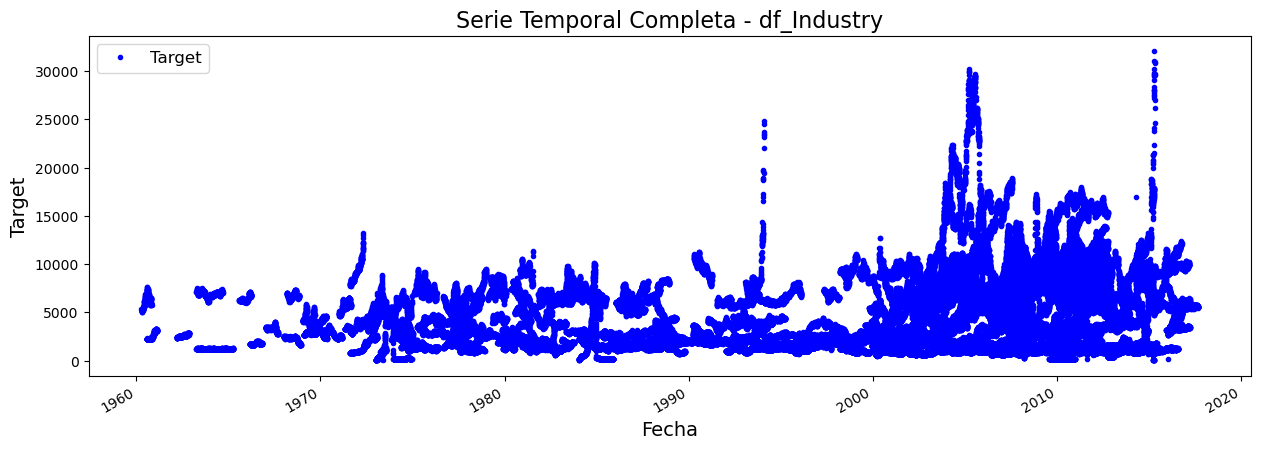

In [33]:
# Gráph 
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_Industry["target"],".", color="blue", label="Target")
ax.set_title("Serie Temporal Completa - df_Industry", fontsize=16)
ax.set_xlabel("Fecha", fontsize=14)
ax.set_ylabel("Target", fontsize=14)
ax.legend(fontsize=12)
fig.autofmt_xdate()
plt.show()
#As we can observe in the graph, there is more than one timeseries in the dataset.

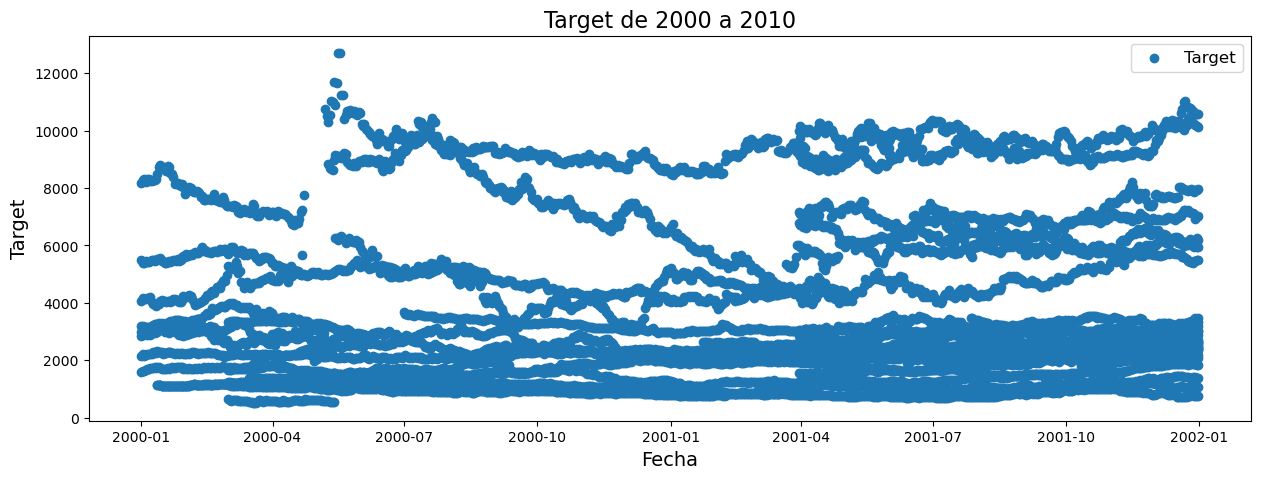

In [34]:
# Select the interval from 2000 to 2001
df_subset = df_Industry.sort_index().loc['2000-01-01':'2001-12-31', :]

# Graficar el target para el periodo seleccionado
plt.figure(figsize=(15, 5))
plt.scatter(df_subset.index, df_subset["target"], label="Target")
plt.title("Target de 2000 a 2010", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Target", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [35]:
df_Industry[df_Industry["id"]=="T002014"]["timestamp"].describe()
#The dataseries to work in is going to be the one with the most quantity of data. 
#The first year of the data is 2000 and the maximum is 2012

count                   4569
mean     2006-06-02 12:00:00
min      2000-03-01 12:00:00
25%      2003-04-17 12:00:00
50%      2006-06-02 12:00:00
75%      2009-07-18 12:00:00
max      2012-09-02 12:00:00
Name: timestamp, dtype: object

In [36]:
df_Industry_1=df_Industry[df_Industry["id"]=="T002014"]

In [37]:
df_Industry_1 = df_Industry_1.drop(columns=["category"]).sort_index(ascending=True)
df_Industry_1.head(10)

,id,timestamp,target
timestamp,,,
2000-03-01 12:00:00,T002014,2000-03-01 12:00:00,1648.4
2000-03-02 12:00:00,T002014,2000-03-02 12:00:00,1671.4
2000-03-03 12:00:00,T002014,2000-03-03 12:00:00,1673.9
2000-03-04 12:00:00,T002014,2000-03-04 12:00:00,1680.5
2000-03-05 12:00:00,T002014,2000-03-05 12:00:00,1692.7
2000-03-06 12:00:00,T002014,2000-03-06 12:00:00,1685.9
2000-03-07 12:00:00,T002014,2000-03-07 12:00:00,1705.0
2000-03-08 12:00:00,T002014,2000-03-08 12:00:00,1705.2
2000-03-09 12:00:00,T002014,2000-03-09 12:00:00,1690.8


In [38]:
df_Industry_1.shape

(4569, 3)

In [39]:
df_Industry_1["target"].isnull().sum()

0

In [40]:
#Verify if the timestamp is complete and continuous
start_date = df_Industry_1.index.min()
print("Start date:", start_date)
end_date = df_Industry_1.index.max()
print("End date:", end_date)

Start date: 2000-03-01 12:00:00
End date: 2012-09-02 12:00:00


In [41]:
complete_date_range = pd.date_range(start=start_date, end=end_date, freq="D")


In [42]:
missing_dates = complete_date_range.difference(m4_df["timestamp"])
print("Missing dates:", missing_dates)
#The timeseries is continues and complete, so we can work with it.

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [43]:
len(missing_dates)

0

In [44]:
df_Industry_1.rename(columns={"id": "item_id"}, inplace=True)

In [45]:
df_Industry_1.head(10)

,item_id,timestamp,target
timestamp,,,
2000-03-01 12:00:00,T002014,2000-03-01 12:00:00,1648.4
2000-03-02 12:00:00,T002014,2000-03-02 12:00:00,1671.4
2000-03-03 12:00:00,T002014,2000-03-03 12:00:00,1673.9
2000-03-04 12:00:00,T002014,2000-03-04 12:00:00,1680.5
2000-03-05 12:00:00,T002014,2000-03-05 12:00:00,1692.7
2000-03-06 12:00:00,T002014,2000-03-06 12:00:00,1685.9
2000-03-07 12:00:00,T002014,2000-03-07 12:00:00,1705.0
2000-03-08 12:00:00,T002014,2000-03-08 12:00:00,1705.2
2000-03-09 12:00:00,T002014,2000-03-09 12:00:00,1690.8


In [46]:
# Now we can create the TimeSeriesDataFrame
data = TimeSeriesDataFrame.from_data_frame(df_Industry_1)
data.head()

target
item_id timestamp                  
T002014 2000-03-01 12:00:00  1648.4
        2000-03-02 12:00:00  1671.4
        2000-03-03 12:00:00  1673.9
        2000-03-04 12:00:00  1680.5
        2000-03-05 12:00:00  1692.7

In [47]:
train_data, test_data = train_test_split(df_Industry_1, test_size=0.2, shuffle=False)
len_train = len(train_data)
len_test = len(test_data)

In [48]:
print("Train data: " ,len_train ,"&", "Test_data : ", len_test)

Train data:  3655 & Test_data :  914


In [63]:

train_data, test_data = train_test_split(df_Industry_1, test_size=0.2, shuffle=False)
len_train = len(train_data)
len_test = len(test_data)

prediction_length_percentage=[1,0.05,0.25,0.5,0.75]
historical_remove_percentage=[0, 0.05,0.25,0.5,0.75]

#Create results table 
errors_df= pd.DataFrame(columns=["Train_size","Percentage_train", "Test_size", "Percentage_test", "MASE_error", "Diference_MASE", "WQL_error", "Diference_WQL"])
row= 0


for j in historical_remove_percentage: 

    #This is the Train data
    historical_length=round(len_train*(1-j))
    historical_length=int(round(len_train*(1-j)))
    print(historical_length)

    for i in prediction_length_percentage:

        prediction_length=round(len_test*i)
        prediction_length=int(round(len_test*i))
        print(prediction_length)
        print(train_data.iloc[-historical_length:,:])

        #Fit the models
        pred_wql, pred_mase= fc.fit_models(prediction_length=prediction_length, train_data=train_data, historical_length=historical_length)

        #Remove the oldest data according to the necesary historical_length and predict just the necessary prediction_length
        complete_data = pd.concat([train_data.iloc[historical_length:], test_data.iloc[:prediction_length]])
  
        evaluation_metrics_WQL = pred_wql.evaluate(complete_data)
        evaluation_metrics_MASE = pred_mase.evaluate(complete_data)

        train_data_relative= len_train-historical_length

        #Add to the table
        errors_df = fc.update_table(
            errors_df,
            row,
            train_data_relative,
            f"{j*100}%",
            prediction_length,
            f"{i*100}%",
            evaluation_metrics_MASE["MASE"],
            evaluation_metrics_WQL["WQL"])
        row+=1



Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250703_191350'


=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.06 GB / 7.37 GB (14.3%)
Disk Space Avail:   7.24 GB / 475.75 GB (1.5%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 914,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}



3655
914
                     item_id           timestamp  target
timestamp                                               
2000-03-01 12:00:00  T002014 2000-03-01 12:00:00  1648.4
2000-03-02 12:00:00  T002014 2000-03-02 12:00:00  1671.4
2000-03-03 12:00:00  T002014 2000-03-03 12:00:00  1673.9
2000-03-04 12:00:00  T002014 2000-03-04 12:00:00  1680.5
2000-03-05 12:00:00  T002014 2000-03-05 12:00:00  1692.7
...                      ...                 ...     ...
2010-02-27 12:00:00  T002014 2010-02-27 12:00:00  8950.9
2010-02-28 12:00:00  T002014 2010-02-28 12:00:00  8951.6
2010-03-01 12:00:00  T002014 2010-03-01 12:00:00  8892.2
2010-03-02 12:00:00  T002014 2010-03-02 12:00:00  8893.4
2010-03-03 12:00:00  T002014 2010-03-03 12:00:00  8947.4

[3655 rows x 3 columns]


IndexError: single positional indexer is out-of-bounds

In [ ]:
errors_df

   Train_size Test_size MASE_error Diference_MASE WQL_error Diference_WQL
0           0       914  -6.364384              0 -0.185506             0
1           0        46  -0.415724       5.948659 -0.017024      0.168481
2           0       228  -1.284598       0.868874 -0.038531      0.021507
3           0       457  -4.050998       2.766399 -0.127673      0.089142
4           0       686   -4.74118       0.690182 -0.144747      0.017074
5         183       914  -6.081281       1.340101 -0.185506      0.040758
6         183        46  -0.397232       5.684049 -0.017024      0.168481
7         183       228  -1.227456       0.830224 -0.038531      0.021507
8         183       457    -3.8708       2.643343 -0.127673      0.089142
9         183       686  -4.530281       0.659481 -0.144747      0.017074
10        914       914  -4.962313       0.432032 -0.185506      0.040758
11        914        46   -0.32414       4.638172 -0.017024      0.168481
12        914       228  -1.001602    

In [ ]:
#Which configurations retrieve the minimum error? 
#Which ones retrieve the maximum one? 

#How is the behavior of the error? Make a graph
#The less old data the better ???????? 

In this table it is possible to observe that when 


In [ ]:
prediction_length=int(round(len_test*0.01))
print("Prediction length: ", prediction_length)

Prediction length:  9


In [ ]:
predictor_WQL= TimeSeriesPredictor(prediction_length=prediction_length,eval_metric="WQL").fit(
    train_data, presets="bolt_small" #if use_cuda else "bolt_small"
    ,
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250518_140043'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.55 GB / 7.37 GB (7.5%)
Disk Space Avail:   35.61 GB / 475.75 GB (7.5%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 9,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 3655 rows, 1 tim

In [ ]:
predictor_MASE=TimeSeriesPredictor(prediction_length=prediction_length,eval_metric="MASE").fit(
    train_data, presets="bolt_small" #if use_cuda else "bolt_small"
    ,
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250518_140048'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.27 GB / 7.37 GB (3.6%)
Disk Space Avail:   35.61 GB / 475.75 GB (7.5%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 9,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 3655 rows, 1 ti

In [ ]:
test_data.iloc[:prediction_length,:]

,item_id,timestamp,target
timestamp,,,
2010-03-04 12:00:00,T002014,2010-03-04 12:00:00,8895.4
2010-03-05 12:00:00,T002014,2010-03-05 12:00:00,8836.5
2010-03-06 12:00:00,T002014,2010-03-06 12:00:00,8556.9
2010-03-07 12:00:00,T002014,2010-03-07 12:00:00,8662.3
2010-03-08 12:00:00,T002014,2010-03-08 12:00:00,8817.7
2010-03-09 12:00:00,T002014,2010-03-09 12:00:00,8744.2
2010-03-10 12:00:00,T002014,2010-03-10 12:00:00,8671.2
2010-03-11 12:00:00,T002014,2010-03-11 12:00:00,8851.4
2010-03-12 12:00:00,T002014,2010-03-12 12:00:00,8758.7


In [ ]:
complete_data = pd.concat([train_data, test_data.iloc[:prediction_length,:]])

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small" #if use_cuda else "bolt_small"
    ,
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\UdeA\Deep NL\Project\DeepNLP_Forecasting\AutogluonModels\ag-20250518_142621'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       0.93 GB / 7.37 GB (12.6%)
Disk Space Avail:   27.80 GB / 475.75 GB (5.8%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 9,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 3655 rows, 1 ti

In [ ]:
evaluation_metrics = predictor_WQL.evaluate(complete_data)
print(evaluation_metrics)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


{'WQL': -0.011154310299712176}


In [ ]:
evaluation_metrics_MASE = predictor_MASE.evaluate(complete_data)
print(evaluation_metrics_MASE)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


{'MASE': -0.3091361484954353}


In [ ]:
errors_df= pd.DataFrame(columns=["Train_size","Test_size", "MASE_error", "Diference_MASE", "WQL_error", "Diference_WQL"])

In [ ]:
errors_df.loc[0, "Diference_MASE"] = 0
errors_df.loc[0, "Diference_WQL"] = 0

In [ ]:
errors_df.loc[0, "Train_size"] = len_train
errors_df.loc[0, "Test_size"] = len_test
errors_df.loc[0, "MASE_error"] = evaluation_metrics_MASE["MASE"] #The initial error is with the whole dataset
errors_df.loc[0, "WQL_error"] = evaluation_metrics["WQL"] #The initial error is with the whole dataset

In [ ]:
errors_df

,Train_size,Test_size,MASE_error,Diference_MASE,WQL_error,Diference_WQL
0,3655,914,-0.541593,0,-0.008049,0


In [ ]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


In [ ]:
print(predictions)

                                    mean          0.1          0.2  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8861.537109  8638.015625  8725.077148   
        2010-03-05 12:00:00  8843.645508  8566.671875  8666.236328   
        2010-03-06 12:00:00  8846.398438  8542.627930  8642.883789   
        2010-03-07 12:00:00  8865.844727  8527.414062  8639.757812   
        2010-03-08 12:00:00  8831.139648  8477.458008  8595.448242   
        2010-03-09 12:00:00  8858.715820  8473.966797  8596.961914   
        2010-03-10 12:00:00  8849.948242  8442.547852  8573.353516   
        2010-03-11 12:00:00  8792.218750  8379.011719  8506.894531   
        2010-03-12 12:00:00  8741.097656  8301.008789  8438.657227   

                                     0.3          0.4          0.5  \
item_id timestamp                                                    
T002014 2010-03-04 12:00:00  8778.553711  8819.754883  8861.537109   
        2010-03-05 

In [ ]:
#We need to part from the baseline with 

In [ ]:
test_data.iloc[:prediction_length,:]

,item_id,timestamp,target
timestamp,,,
2010-03-04 12:00:00,T002014,2010-03-04 12:00:00,8895.4
2010-03-05 12:00:00,T002014,2010-03-05 12:00:00,8836.5
2010-03-06 12:00:00,T002014,2010-03-06 12:00:00,8556.9
2010-03-07 12:00:00,T002014,2010-03-07 12:00:00,8662.3
2010-03-08 12:00:00,T002014,2010-03-08 12:00:00,8817.7
2010-03-09 12:00:00,T002014,2010-03-09 12:00:00,8744.2
2010-03-10 12:00:00,T002014,2010-03-10 12:00:00,8671.2
2010-03-11 12:00:00,T002014,2010-03-11 12:00:00,8851.4
2010-03-12 12:00:00,T002014,2010-03-12 12:00:00,8758.7


In [ ]:
# 
complete_data = pd.concat([train_data, test_data.iloc[:prediction_length,:]])

In [ ]:
evaluation_metrics = predictor.evaluate(complete_data)
print(evaluation_metrics)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


{'WQL': -0.011154310299712176}


----------------------------------------------------------

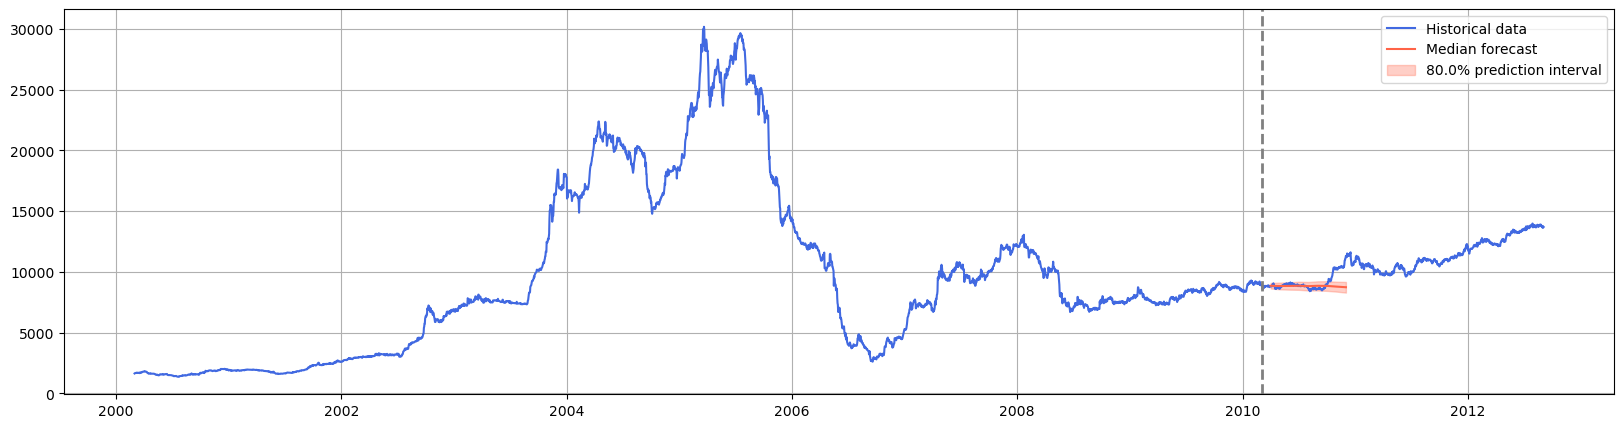

In [ ]:
low, median, high = predictions.loc[:, "0.1"], predictions.loc[:, "0.5"], predictions.loc[:, "0.9"]
start_forecasting_date = test_data.index.get_level_values("timestamp")[0]
plot_timeseries_forecasting(df_Industry_1.iloc[:,2], low, median, high,
                            start_forecasting_date=start_forecasting_date,
                            prediction_length=prediction_length)

## Demography dataset

In [ ]:
df_Demography.head(10)

,id,timestamp,target,category
1603,T001603,1997-03-01 12:00:00,138.8524,Demographic
1603,T001603,1997-03-02 12:00:00,140.4125,Demographic
1603,T001603,1997-03-03 12:00:00,138.6265,Demographic
1603,T001603,1997-03-04 12:00:00,141.9203,Demographic
1603,T001603,1997-03-05 12:00:00,148.3013,Demographic
1603,T001603,1997-03-06 12:00:00,146.8035,Demographic
1603,T001603,1997-03-07 12:00:00,143.7627,Demographic
1603,T001603,1997-03-08 12:00:00,152.0674,Demographic
1603,T001603,1997-03-09 12:00:00,161.0877,Demographic
1603,T001603,1997-03-10 12:00:00,163.0214,Demographic


In [ ]:
#Check fot nulls in the target column
df_Demography["target"].isnull().sum()

0